# Veri setimizde 851 tane veri bulunmaktadır ve 2 sütundan oluşmaktadır.Veri setimizde Haber,makale ve video içeriklerinden alınmış 851 tane text bulunmaktadır.Bu metinlerin karşılarında etiket olarak çocuğun karşısına çıkarılıp çıkarılamayacağını belirten adult veye non-adult şeklinde etiketler bulunmaktadır. 

# Excel dosyaısnın csv'ye dönüştürülmesi

# Bu kısımda excel formatındaki veriler csv formatına dönüştürülmüştür.

In [1]:
import pandas as pd

# Excel dosyasını oku
excel_dosyasi = "final_adult_content.xlsx"  # dosya adını buraya yaz
df = pd.read_excel(excel_dosyasi)

# CSV olarak kaydet
df.to_csv("veriler.csv", index=False)


# Veri Setinin İlk 5 satırının Ekranda Gösterilmesi

# Oluşturulan csv dosyasının ilk 5 satırı ekranda gösterilmektedir.

In [2]:
df.head()

,Description,Category
0,Washington Correspondent New York Magazine Wri...,Non_Adult
1,Host of NPR s Pop Culture Happy Hour Author NY...,Non_Adult
2,Gay Men Ring Free gay tube for mature gay men ...,Adult
3,SeeMomSuck is packed with the best Amateur Ste...,Adult
4,xReview com provides in depth porn site review...,Adult


# Veri Ön işleme Adımları

# Bu kısımda csv dosyasındaki boş olan kısımlar temizlenmiş ve etiketleri 0 non-adult(yetişkin değil) 1 adult(yetişkin) şeklinde sayısallaştırılmıştır.

In [3]:
import pandas as pd

# Veriyi oku
df = pd.read_csv("veriler.csv")  # Dosya adını kendi CSV dosyana göre değiştir

# NaN verileri sil ve gerekli sütunları al
df = df[['Description', 'Category']].dropna()

# Etiketleri sayısal değerlere dönüştür
df['label'] = df['Category'].map({'Non_Adult': 0, 'Adult': 1})
df = df.drop(columns=['Category'])



# Veri ön işlemeden sonraki veri seti

# Bu kısımda veri ön işlemeden sonraki veri setinin yeni halini görmektesiniz.

In [4]:
df

,Description,label
0,Washington Correspondent New York Magazine Wri...,0
1,Host of NPR s Pop Culture Happy Hour Author NY...,0
2,Gay Men Ring Free gay tube for mature gay men ...,1
3,SeeMomSuck is packed with the best Amateur Ste...,1
4,xReview com provides in depth porn site review...,1
...,...,...
845,Free downloads of mobile porn in 3gp mp4 video...,0
846,Your Daily Girls features new porn galleries u...,0
847,Tweeting breaking news from CTVNews ca in the ...,1
848,Political editor Nine News Co author of The Ma...,1


#  Eğitim ve Test Setlerine Ayır

# Bu kısımda %20 test ve %80 eğitim olarak veri setimizi böldük.

In [5]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Description'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)


# Tokenizer (BERT) Hazırla

# BERT Tokenizer Nedir?

    BERT, ham metni doğrudan anlamaz, önce metni token denilen küçük parçalara (kelimeler, kelime parçaları veya özel semboller) böler.

    Bu işleme tokenization denir.

    Tokenizer, metni bu tokenlara böler ve her tokena benzersiz bir sayı (ID) atar. Böylece metin, sayısal bir diziye dönüşür..

# bert-base-uncased: BERT modelinin küçük harfli (uppercase, yani büyük harf duyarsız) versiyonunun tokenizer’ını indirip kullanıyoruz.

# Bu tokenizer, BERT’in eğitiminde kullanılan özel sözcük parçalama kurallarını ve kelime sözlüğünü içeriyor.

In [6]:
# Hugging Face'in Transformers kütüphanesinden BERT tokenizer'ını içe aktar
from transformers import BertTokenizer

# 'bert-base-uncased' modeline ait tokenizer'ı yükle
# Bu tokenizer, BERT'in küçük harfli (uncased) versiyonu için eğitimde kullanılan sözcük parçalama (tokenization) kurallarını içerir
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Eğitim metinlerini tokenize et
# truncation=True → Uzun cümleleri 128 token ile sınırla (fazlasını kes)
# padding=True → Kısa cümleleri 128 token'a eşitlemek için boşluk token'ları (padding) ekle
# max_length=128 → Tüm girdiler için maksimum uzunluk 128 token
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)

# Test metinlerini tokenize et
# Aynı parametrelerle test verisini de hazırla
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)



# Torch Dataset oluştur

# `AdultDataset` sınıfı, BERT için tokenize edilmiş metinleri ve etiketleri PyTorch tensörlerine dönüştürerek eğitim ve test verilerini `Dataset` formatına getirir. Bu sayede veriler, modelin eğitimi ve değerlendirmesi için kolayca `Trainer` veya `DataLoader` ile kullanılabilir.


In [7]:
import torch

# PyTorch'un Dataset sınıfını kullanarak özel bir veri seti tanımlarız
class AdultDataset(torch.utils.data.Dataset):
    # Sınıf başlatılırken token'lanmış veriler (encodings) ve etiketler (labels) alınır
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Girdi verileri (input_ids, attention_mask vb.)
        self.labels = labels        # Etiket verileri (0 veya 1 gibi sınıf bilgisi)

    # Dataset'in kaç etiket içerdiğini döndürür
    def __len__(self):
        return len(self.labels)

    # Belirli bir indeks için token'lanmış verileri ve etiketi döndürür
    def __getitem__(self, idx):
        # input_ids, attention_mask gibi her bir öğeyi tensor'a çevirip dict'e ekler
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Aynı şekilde etiket de tensor olarak eklenir
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Eğitim verileri için dataset nesnesi oluşturuluyor
train_dataset = AdultDataset(train_encodings, train_labels)


# Test verileri için dataset nesnesi oluşturuluyor
test_dataset = AdultDataset(test_encodings, test_labels)



# Bert Modelini Yükle

# Bu kod, metin sınıflandırma için önceden eğitilmiş `bert-base-uncased` modelini yükler. Modelin çıkış katmanı, iki sınıfı (örneğin "Adult" ve "Non\_Adult") ayırt edebilecek şekilde yapılandırılır (`num_labels=2`).


In [8]:
# Hugging Face Transformers kütüphanesinden metin sınıflandırma için BERT modelini içe aktar
from transformers import BertForSequenceClassification

# Önceden eğitilmiş 'bert-base-uncased' modelini yükle ve iki sınıflı bir çıktı katmanı ekle
# num_labels=2 → Çıktı katmanı iki sınıf (örneğin: 'Adult' ve 'Non_Adult') için yapılandırılır
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Eğitim Ayarları

# Bu kod, BERT modelinin eğitim sürecinde kullanılacak parametreleri belirler; örneğin kaç epoch çalışılacağı, batch boyutları, öğrenme oranı ısınması ve ağırlık çürümesi gibi ayarları yapar. Ayrıca eğitim ilerlemesini kaydetmek için log dosyalarının nerede tutulacağını ve kaç adımda bir log alınacağını belirtir.

In [9]:
from transformers import TrainingArguments  # Transformers kütüphanesinden eğitim parametrelerini ayarlamak için sınıfı içe aktarır

# Model eğitimi için parametrelerin ayarlandığı sınıf örneği oluşturuluyor
training_args = TrainingArguments(
    output_dir="./results",                # Eğitim sonunda oluşan model, checkpoint ve diğer dosyaların kaydedileceği klasör yolu
    num_train_epochs=5,                    # Modelin eğitim verisi üzerinde kaç kere (epoch) tamamen çalışacağı (burada 3 kez)
    per_device_train_batch_size=8,        # Eğitim sırasında her bir cihaz (GPU/CPU) için kullanılacak mini-batch büyüklüğü
    per_device_eval_batch_size=8,         # Doğrulama (validation) sırasında her cihazda kullanılacak batch boyutu
    warmup_steps=10,                      # Öğrenme oranının (learning rate) başlangıçta kademeli olarak artacağı adım sayısı (modelin eğitime yumuşak başlaması için)
    weight_decay=0.01,                    # Modelin aşırı uyum (overfitting) yapmasını önlemek için ağırlıkların zamanla küçültülme oranı (L2 regularizasyonu)
    logging_dir="./logs",                 # Eğitim sürecinde oluşan log dosyalarının kaydedileceği klasör (örneğin eğitim kaybı, doğruluk gibi metrikler)
    logging_steps=10,                     # Eğitim sırasında her 10 adımda bir loglama yapılarak eğitim durumu kaydedilir ve izlenebilir
    metric_for_best_model="accuracy", 
    
)


# Model Doğruluk Hesaplama Fonksiyonu

# Bu fonksiyon, modelin tahmin ettiği sınıflarla gerçek etiketleri karşılaştırarak doğruluk (accuracy) değerini hesaplar. Eğitim ve değerlendirme aşamalarında performans ölçümü için kullanılır.

In [10]:
# sklearn kütüphanesinden doğruluk hesaplamak için gerekli fonksiyonu içe aktar
from sklearn.metrics import accuracy_score
# NumPy kütüphanesini içe aktar (sayısal işlemler için)
import numpy as np

# Model değerlendirme sırasında kullanılacak metrikleri hesaplayan fonksiyon
def compute_metrics(eval_pred):
    # eval_pred, model çıktısı olan logits ve gerçek etiketleri (labels) içeren bir tuple'dır
    logits, labels = eval_pred
    # Logits değerlerinden en yüksek olasılığa sahip sınıfı seç (tahminleri çıkar)
    predictions = np.argmax(logits, axis=-1)
    # Gerçek etiketlerle tahmin edilen sınıfları karşılaştırarak doğruluk oranını hesapla
    acc = accuracy_score(labels, predictions)
    # Doğruluk oranını sözlük formatında döndür (Trainer bu formatı kullanır)
    return {"accuracy": acc}





# Transformer Trainer Nesnesi Oluşturma

# Bu kod, modelin eğitim ve değerlendirme süreçlerini yönetmek için Trainer nesnesini yapılandırır ve eğitim parametreleri, veri setleri ile doğruluk hesaplama fonksiyonunu bağlar.

In [11]:
from transformers import Trainer, EarlyStoppingCallback

# Trainer objesi oluşturuluyor
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    
)


In [12]:
train_accuracies = []
eval_accuracies = []
train_losses = []
eval_losses = []

# 5 epochluk eğitim tek seferde yapılır
train_result = trainer.train()

# Eğitim sonunda train seti değerlendirme
train_metrics = trainer.evaluate(train_dataset)
train_accuracies.append(train_metrics.get('eval_accuracy'))
train_losses.append(train_metrics.get('eval_loss'))

# Eğitim sonunda test seti değerlendirme
eval_metrics = trainer.evaluate(test_dataset)
eval_accuracies.append(eval_metrics.get('eval_accuracy'))
eval_losses.append(eval_metrics.get('eval_loss'))

print(f"Train Acc: {train_accuracies[-1]:.4f}, Train Loss: {train_losses[-1]:.4f}, Eval Acc: {eval_accuracies[-1]:.4f}, Eval Loss: {eval_losses[-1]:.4f}")

C:\Users\atunc\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.661300
20,0.368900
30,0.193100
40,0.302100
50,0.055300
60,0.226500
70,0.298400
80,0.343100
90,0.235500
100,0.223000


C:\Users\atunc\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


C:\Users\atunc\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Acc: 0.9897, Train Loss: 0.0386, Eval Acc: 0.8824, Eval Loss: 0.6327


In [17]:
print("\n--- Eğitim Tamamlandı ---")
print(f"Son Eğitim Doğruluğu: {train_accuracies[-1]:.4f}")
print(f"Son Eğitim Değerlendirme Kaybı: {train_losses[-1]:.4f}")
print(f"Son Test Doğruluğu: {eval_accuracies[-1]:.4f}")
print(f"Son Test Kaybı: {eval_losses[-1]:.4f}")



--- Eğitim Tamamlandı ---
Son Eğitim Doğruluğu: 0.9897
Son Eğitim Değerlendirme Kaybı: 0.0386
Son Test Doğruluğu: 0.8824
Son Test Kaybı: 0.6327


In [18]:
# Modelin test seti üzerindeki tahminleri
predictions = trainer.predict(test_dataset)

# Tahmin edilen sınıf etiketleri
y_pred = np.argmax(predictions.predictions, axis=1)

# Gerçek sınıf etiketleri
y_true = predictions.label_ids


C:\Users\atunc\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


C:\Users\atunc\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


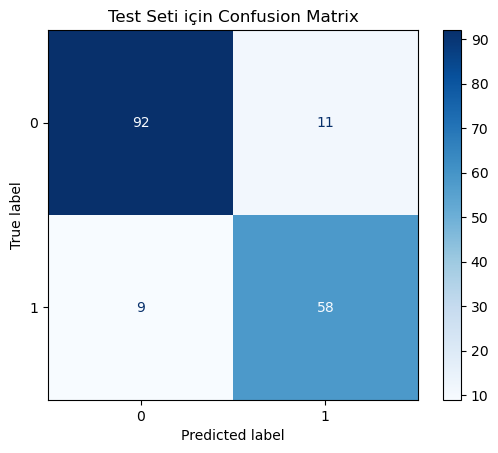

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Model tahminleri
predictions = trainer.predict(test_dataset)

# Tahmin edilen etiketler
y_pred = np.argmax(predictions.predictions, axis=1)

# Gerçek etiketler
y_true = predictions.label_ids

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Test Seti için Confusion Matrix")
plt.show()


In [20]:
# Modeli ve tokenizer'ı belirtilen klasöre kaydet
output_dir = "./results"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model ve tokenizer başarıyla kaydedildi.")


Model ve tokenizer başarıyla kaydedildi.
